In [2]:
from matplotlib import colormaps
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple, Dict
import pandas as pd
import os
import re
import json
import subprocess
import numpy as np
from scipy import stats
from collections import defaultdict, namedtuple
from sklearn.cluster import DBSCAN
import math as ma

#### Global variables

In [3]:
TRACE_CMD_CACHE_FILENAME = "trace_cmd_runtimes"
RESULTS_DIR_PATH = "../results"
ABSOLUTE_RESULTS_DIR_PATH = "/home/cgachod/analysis/results"

WORKING_DIR = "/root/tests"
PERF_SCRIPT_RESULTS_FILEPATH = f"{WORKING_DIR}/.perf_mem_results.log"

NODE_1_PHYS_ADDR_START = 0x1840000000

DAHU_NODE_0_CPUID = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62]
DAHU_NODE_1_CPUID = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63]
dahu_cpu_nodes = [1 if cpuid in DAHU_NODE_1_CPUID else 0 for cpuid in range(64)]

def in_working_dir(path: str) :
    return os.path.join(WORKING_DIR, path)

def get_result_dir_path(result_dir_name):
    return os.path.join(RESULTS_DIR_PATH, result_dir_name)

def get_absolute_result_dir_path(result_dir_name) :
    return os.path.join(ABSOLUTE_RESULTS_DIR_PATH, result_dir_name)

#### Visualization params

In [4]:
nb_enabled_color = "tab:orange"
nb_disabled_color = "tab:blue"

figure_height = 10 # 10
min_figure_width = 40
figure_width_coeff = 0.3

line_width = 1.0

Idea is to represent where each core accesses memory
- Sort cores by node
- For each core, have a timeline or maybe just a percentage of time where it accesses which node
- Maybe we can have 2 histograms, one up which is local node and 1 down which is remote 

In [5]:
# So for that we only need cpu and memory address and time
# We assume we have the perf data file

# 1: pid, 2: tid, 3: cpuid, 4: time, 5: period, 6: event , 7: virtual address
# basic_info_regex_str = r"^ *[\w\/\-\.\: ]+ +(\d+) \[(\d+)\] (\d+\.\d+): +([\w\/\-\.]+).*?: +([0-9a-f]+)"
basic_info_regex_str = r"^ *[\w\/\-\.\:]+ +(\d+)\/(\d+) +\[(\d+)\] +(\d+\.\d+): +(\d+) +([\w\/\-\.]+).*?: +([0-9a-f]+)"

# 8: memory access type, 9: TLB access type
data_src_regex_str = r"[0-9a-f]+ \|OP (?:LOAD|STORE)\|([^\|]+)\|[^\|]+\|(TLB [^\|]+)\|[^\|]+\|[a-zA-Z\/\- ]+"
phys_addr_regex_str = r"([0-9a-f]+)"
# data_src_regex = re.compile()

line_regex = re.compile(basic_info_regex_str + r"\s+" + data_src_regex_str + phys_addr_regex_str)

def generate_perf_mem_log(file_path: str) -> dict :
    command_str = f"perf script -i {file_path} -c cg.C.x -F 'comm,pid,tid,cpu,time,period,event,addr,data_src,phys_addr' --time 10%-20% > {PERF_SCRIPT_RESULTS_FILEPATH}"
    print(command_str)
    result = subprocess.run(
        command_str,
        shell=True,
        stdout = subprocess.PIPE,
        universal_newlines = True
    )
    
# perf script -L -F 'comm,pid,tid,cpu,time,addr,event,ip,phys_addr,data_src,period' --reltime --time 1.0,2.0

In [6]:
resgex = line_regex.match("          cg.C.x 10674/10674 [000]  2789.844649:      26661         cpu/mem-stores/P: ffffe9b88d9bfcd0      1e05080144 |OP STORE|LVL L1 or N/A hit|SNP N/A|TLB N/A|LCK N/A|BLK  N/A                                0")
print(resgex.group(6)[4:14] == "mem-stores")

True


In [ ]:
generate_perf_mem_log(in_working_dir("perf-mem-15-alone.data"))

In [10]:
def build_events_df(filepath: str) -> pd.DataFrame :
    timestamp = []
    cpuid = []
    event = []
    virtual_addr = []
    physical_addr = []
    cache_result = []
    period = []

    # filename = "assets/perf_mem_sample.log"
    # filename = "assets/.perf_mem_results.log"
    with open(filepath) as f :
        for line in f :
            matched = line_regex.match(line)
            if matched :
                event.append(matched[6])
                timestamp.append(float(matched[4]))
                cpuid.append(int(matched[3]))
                cache_result.append(matched[8])
                virtual_addr.append(int(matched[7], base=16))
                physical_addr.append(int(matched[10], base=16))
                period.append(int(matched[5]))
                pass
            else :
                print("Not matched line : ", line)
                
    dahu_cpu_nodes_map = {cpuid: 1 if cpuid in DAHU_NODE_1_CPUID else 0 for cpuid in range(64)}
    
    events_df = pd.DataFrame({
        "time": timestamp, 
        "cpuid": cpuid,  
        "event": event,
        "virt": virtual_addr, 
        "phys": physical_addr, 
        "cache_result": cache_result, 
        "period": period
    })
    events_df['time'] = events_df['time'] - events_df['time'].min()
    # accesses_df['time_offset'] = accesses_df['time'].diff()
    events_df['cpu_node'] = events_df['cpuid'].map(dahu_cpu_nodes_map)
    events_df['memory_node'] = (events_df['phys'] >= NODE_1_PHYS_ADDR_START).astype(int)
    return events_df

In [11]:
def build_memory_accesses_dfs(filepath: str) -> Tuple[pd.DataFrame, pd.DataFrame] :
    # loads, stores
    is_store = []
    timestamp = []
    cpuid = []
    virtual_addr = []
    physical_addr = []
    cache_result = []
    period = []

    # filename = "assets/perf_mem_sample.log"
    # filename = "assets/.perf_mem_results.log"
    with open(filepath) as f :
        for line in f :
            matched = line_regex.match(line)
            if matched :
                is_store.append(int(matched[6][4:14] == "mem-stores"))
                timestamp.append(float(matched[4]))
                cpuid.append(int(matched[3]))
                cache_result.append(matched[8])
                virtual_addr.append(int(matched[7], base=16))
                physical_addr.append(int(matched[10], base=16))
                period.append(int(matched[5]))
                pass
            else :
                print("Not matched line : ", line)
                
    dahu_cpu_nodes_map = {cpuid: 1 if cpuid in DAHU_NODE_1_CPUID else 0 for cpuid in range(64)}
    
    accesses_df = pd.DataFrame({
        "time": timestamp, 
        "cpuid": cpuid,  
        "virt": virtual_addr, 
        "phys": physical_addr, 
        "cache_result": cache_result, 
        "period": period,
        "is_store": is_store
    })
    accesses_df['time'] = accesses_df['time'] - accesses_df['time'].min()
    # accesses_df['time_offset'] = accesses_df['time'].diff()
    accesses_df['cpu_node'] = accesses_df['cpuid'].map(dahu_cpu_nodes_map)
    accesses_df['memory_node'] = (accesses_df['phys'] >= NODE_1_PHYS_ADDR_START).astype(int)
    accesses_df = accesses_df.loc[accesses_df['phys'] != 0]
    
    loads_df = accesses_df.loc[accesses_df["is_store"] == 0]
    loads_df['time_offset'] = loads_df['time'].diff()
    
    stores_df = accesses_df.loc[accesses_df["is_store"] == 1]
    stores_df['time_offset'] = stores_df['time'].diff()
    
    return loads_df.iloc[1:], stores_df.iloc[1:]

In [7]:
# 6 664 894 lines
loads_df, stores_df = build_memory_accesses_dfs(in_working_dir("perf.log"))

In [12]:
events_df = build_events_df(in_working_dir("perf.log"))

In [ ]:
loads_df

In [ ]:
stores_df

In [ ]:
# stores_df.loc[stores_df['cache_result'] == "LVL L1 or N/A hit"]

In [ ]:
# plt.cm.Spectral_r([0,1])

# for colorname in plt.colormaps() :
#     display(plt.cm.get_cmap(colorname))
# colormaps["turbo"]([100, 128, 196, 70])
# plt.cm.get_cmap("OrRd")

# colormaps["OrRd"]


In [ ]:
def get_cache_results_stats(input_df: pd.DataFrame) :
    period_mean = []
    time_offset_mean = []
    cache_results_counts = input_df['cache_result'].value_counts()
    for key, value in cache_results_counts.items() :
        period_mean.append(input_df.loc[input_df['cache_result'] == key]['period'].mean())
        time_offset_mean.append(input_df.loc[input_df['cache_result'] == key]['time_offset'].mean())
    result_df = cache_results_counts.to_frame()
    result_df['period_mean'] = period_mean
    result_df['time_offset_mean'] = time_offset_mean
    return result_df.sort_values('period_mean', ascending=False)


def plot_cache_results(input_df: pd.DataFrame) :
    period_per_cr = {}
    time_offset_per_cr = {}
    cache_results_counts = input_df['cache_result'].value_counts()
    for key, value in cache_results_counts.items() :
        period_per_cr[key] = input_df.loc[input_df['cache_result'] == key]['period']
        time_offset_per_cr[key] = input_df.loc[input_df['cache_result'] == key]['time_offset']
        
    # Period values
    plt.boxplot(period_per_cr.values(), labels=period_per_cr.keys())
    plt.xticks(rotation=20, ha='right')
    plt.show()
    
    # Time offsets values
    plt.boxplot(time_offset_per_cr.values(), labels=time_offset_per_cr.keys(), showfliers=False, showmeans=True)
    plt.xticks(rotation=20, ha='right')
    # plt.gcf().set_size_inches(12, 50)
    plt.show()
    
    ratio = {key: period_per_cr[key] / time_offset_per_cr[key] for key in period_per_cr.keys()}
    plt.boxplot(ratio.values(), labels=period_per_cr.keys(), showfliers=False, showmeans=True)
    plt.xticks(rotation=20, ha='right')
    # plt.gcf().set_size_inches(12, 50)
    plt.show()
    
plot_cache_results(loads_df)
    
        

In [ ]:
print("Loads cache results stats")
print(get_cache_results_stats(loads_df))

print("\n\nStores cache results stats")
print(get_cache_results_stats(stores_df))

In [ ]:
# def scatter_accesses_for_cpu(accesses_df: pd.DataFrame, cpuid = -1, min_phys = None max_phys = None) :
#     cache_results_df = get_cache_results_stats(accesses_df)
#     color_map = colormaps["turbo"]
#     cache_results_colors = {cache_res_val: color_map(25 * i) for i, cache_res_val in enumerate(period_df.index)}

In [ ]:
# for cmap_id in plt.colormaps():
#     print(cmap_id)
#     display(colormaps[cmap_id])

In [ ]:


# remote_memory_df['cache_result'].value_counts().items() # I want to have value counts and average period for each
period_df = get_cache_results_stats(loads_df)
period_df = period_df.sort_values('period_mean', ascending=False)

print(period_df)

color_map = colormaps["turbo"]
cache_results_colors = {cache_res_val: color_map(25 * i) for i, cache_res_val in enumerate(period_df.index)}


In [22]:
def get_cluster_bounds(values: np.array, eps: int, min_group_size: int):
    sorted_values = np.sort(values)
    
    clusters = []
    curr_lower_idx = 0
    curr_lower_val = sorted_values[0]
    # current_group = [sorted_values[0]]

    for i, val in enumerate(sorted_values):
        group_size = i - curr_lower_idx - 1
        if val - curr_lower_val > eps and group_size >= min_group_size :
            clusters.append((curr_lower_val, sorted_values[i - 1], group_size))
            curr_lower_idx = i
            curr_lower_val = val
            
    return clusters

def filter_in_bounds(df: pd.DataFrame, property: str, bounds: tuple) :
    return df.loc[(df[property] > bounds[0]) & (df[property] < bounds[1])]


# def get_virtual_addrs_clusters(data: dict) -> Tuple[list, list] :
#     return get_clusters_1D(np.concatenate([np.array(cpu['virtual_addrs']) for cpu in data]), 1e7, 10)

In [ ]:
plt.plot(loads_df.index, loads_df['phys'].sort_values())
plt.show()

In [ ]:
load_clusters = get_clusters_1D(loads_df['phys'], 1e8, 100000)
load_clusters

In [ ]:
bounds = load_clusters[0][3]
bounds

Plan :
- Have a graph of the exact phys remote addresses, maybe we can see smth there
- Otherwise scatter all the addresses but y axis only remote vs local node, and color according to type of cache hit

In [ ]:
phys_addr_subset_df = memory_df.loc[(memory_df['phys'] > bounds[0]) & (memory_df['phys'] < bounds[1])]
phys_addr_subset_df

In [ ]:
cpuid = 1
# subset_df = memory_df.loc[(memory_df['cache_result'] in ["LVL L1 or L1 hit", LVL Remote RAM hit])]
subset_df = phys_addr_subset_df.loc[memory_df['cpuid'] == cpuid]



plt.scatter(subset_df["time"], subset_df["phys"], s=6, alpha=0.5, c=colors[n])

subset_df

We want to print all of the accesses for a given CPU, with node 1 or 2 in Y and cache result as colors

In [ ]:
color_map = colormaps["turbo"]
load_cache_results_values = ["LVL LFB/MAB or LFB/MAB hit", "LVL L1 or L1 hit", "LVL L2 or L2 hit", "LVL L3 or L3 hit", "LVL L3 miss", "LVL Local RAM or RAM hit", "LVL Remote Any cache hit", "LVL Remote RAM hit"]
print([color_map((255 / len(load_cache_results_values)) * i) for i, cache_res_val in enumerate(load_cache_results_values)])
load_cache_results_colors = {cache_res_val: color_map(int((255 / len(load_cache_results_values)) * i)) for i, cache_res_val in enumerate(load_cache_results_values)}



# tab10
load_cache_results_colors = {cache_res_val: colormaps["tab10"](i) for i, cache_res_val in enumerate(load_cache_results_values)}
# color_map(100.001)

In [ ]:
def print_node_and_cache_result(df: pd.DataFrame, cache_results_colors: dict, cpuid: int, min_t: float = None, max_t: float = None) :
    cpu_df = df.loc[df['cpuid'] == cpuid]
    cpu_df['is_remote'] = np.int64(cpu_df['cpu_node'] != cpu_df['memory_node'])
    
    if min_t is not None:
        cpu_df = cpu_df.loc[cpu_df['time'] >= min_t]
        
    if max_t is not None:
        cpu_df = cpu_df.loc[cpu_df['time'] <= max_t]
    
    for result, color in cache_results_colors.items():
        # print("Cache result :", result, "color : ")
        subset = cpu_df.loc[cpu_df['cache_result'] == result]
        # print(subset)
        plt.scatter(subset['time'], subset['is_remote'], label=result, color=color, s=6, alpha=0.5)
        # break

    plt.gcf().set_size_inches(120, 10)
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    plt.xlabel('Time')
    plt.ylabel('Phys')
    plt.ylim(-3, 4)
    plt.title('Scatter Plot of Time vs Phys with Cache Results Colored')
    plt.legend(title='Cache Result')
    plt.show()
    
    
def print_address_and_cache_result(df: pd.DataFrame, cache_results_colors: dict, cpuid: int, min_t: float = None, max_t: float = None):
    cpu_df = df.loc[df['cpuid'] == cpuid]
    
    if min_t is not None:
        cpu_df = cpu_df.loc[cpu_df['time'] >= min_t]
        
    if max_t is not None:
        cpu_df = cpu_df.loc[cpu_df['time'] <= max_t]
        
    subset_node0 = cpu_df.loc[cpu_df['memory_node'] == 0]
    subset_node1 = cpu_df.loc[cpu_df['memory_node'] == 1]
    
    def plot_subset(node_df: pd.DataFrame) :
        for result, color in cache_results_colors.items():
            subset = node_df.loc[node_df['cache_result'] == result]
            plt.scatter(subset['time'], subset['phys'], label=result, color=color, s=6, alpha=0.5)

        plt.gcf().set_size_inches(120, 10)
        plt.grid(axis="y", which="both")
        plt.grid(axis="x", which="major")
        plt.xlabel('Time')
        plt.ylabel('Phys')
        plt.title('Scatter Plot of Time vs Phys with Cache Results Colored')
        plt.legend(title='Cache Result')
        plt.show()
        
    plot_subset(subset_node0)
    plot_subset(subset_node1)
    
    # Graph on top : node 0
    # Graph on bottom : node 1

In [ ]:
cpuid = 15
cpu_loads_df = loads_df.loc[loads_df['cpuid'] == cpuid]
cpu_loads_clusters = get_clusters_1D(cpu_loads_df['phys'], 5e8, 100)
cpu_loads_clusters

In [ ]:
# bounds = load_clusters[0][3]
# reduced_loads_df = loads_df.loc[(loads_df['phys'] > bounds[0]) & (loads_df['phys'] < bounds[1])]

bounds = cpu_loads_clusters[0][0]
reduced_loads_df = cpu_loads_df.loc[(cpu_loads_df['phys'] > bounds[0]) & (cpu_loads_df['phys'] < bounds[1])]
# print_node_and_cache_result(reduced_loads_df, load_cache_results_colors, 15, 1.85, 2.0)
print_address_and_cache_result(reduced_loads_df, load_cache_results_colors, 15)
# print_address_and_cache_result

In [ ]:
remote_loads_df = loads_df.loc[loads_df['cpu_node'] != loads_df['memory_node']]

In [ ]:
remote_loads_df

In [ ]:
remote_loads_df['cpuid'].value_counts()

In [ ]:
# remote_memory_df

# fig, ax = plt.subplots()
# colors = 
# colors = {result: plt.cm.tab20(i) for i, result in enumerate(remote_memory_df['cache_result'].unique())}
cache_results_colors
for result, color in cache_results_colors.items():
    # print("Cache result :", result, "color : ")
    subset = remote_loads_df.loc[remote_loads_df['cache_result'] == result]
    # print(subset)
    plt.scatter(subset['time'], subset['phys'], label=result, color=color, s=6, alpha=0.5)
    # break

# fig = plt.gcf()
# if width is None :
#     width = 28
# if height is None :
#     height = 12
plt.gcf().set_size_inches(120, 60)
plt.grid(axis="y", which="both")
plt.grid(axis="x", which="major")
plt.xlabel('Time')
plt.ylabel('Phys')
plt.title('Scatter Plot of Time vs Phys with Cache Results Colored')
plt.legend(title='Cache Result')
plt.show()

## Analyzing cpu loads and remote l3 misses

In [ ]:
# events_df = build_events_df(in_working_dir("perf.log"))

Plot number of l3 remote cache for each CPU. Possibly can be multiplied by the period value

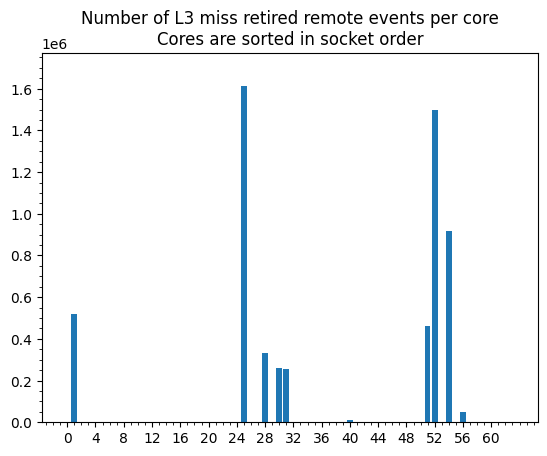

In [44]:
# We want to sort them by node
events_df['cpuid'].unique()

def filter_l3_miss_retired_remote(df: pd.DataFrame) :
    return df.loc[df['event'] == "mem_load_l3_miss_retired.remote_dram"]

l3_remote_df = events_df.loc[events_df['event'] == "mem_load_l3_miss_retired.remote_dram"]
cpu_sorted = [i for i in range(64) if i % 2 == 0] + [i for i in range(64) if i % 2 == 1]

cpu_remote_l3_loads = [l3_remote_df.loc[l3_remote_df['cpuid'] == cpuid]['period'].sum() for cpuid in range(64)] 

# l3_remote_df.groupby('cpuid')['period'].sum().reset_index()

# cpu_total_periods = []

# l3_remote_df.groupby('cpuid').agg(
#     total_period=pd.NamedAgg(column='period', aggfunc='sum'),
#     count=pd.NamedAgg(column='event', aggfunc='count')
# )

plt.bar(range(len(cpu_remote_l3_loads)), cpu_remote_l3_loads)
plt.ylim(0, max(cpu_remote_l3_loads) * 1.1)
plt.xticks([i for i in range(64) if i % 4 == 0])
plt.minorticks_on()
plt.title("Number of L3 miss retired remote events per core\nCores are sorted in socket order")
plt.show()

### We are going to print the addresses of node 0 and node 1 independently

In [32]:
def plot_phys_addresses(df: pd.DataFrame, cluster_eps: int, cluster_min_size: int) :
    phys_clusters = get_cluster_bounds(df['phys'], cluster_eps, cluster_min_size)
    
    for node in [0, 1] :
        node_df = df.loc[df['memory_node'] == node]
        min_phys_addr = node_df['phys'].min()
        max_phys_addr = node_df['phys'].max()
        l3_remote_df = filter_l3_miss_retired_remote(node_df)
        
        plt.plot(node_df.index, node_df['phys'].sort_values())
        for cluster in phys_clusters :
            if min_phys_addr <= cluster[0] <= max_phys_addr :
                plt.axhline(y=cluster[0], color='g', linestyle='--', linewidth=0.2)
            if min_phys_addr <= cluster[1] <= max_phys_addr :
                plt.axhline(y=cluster[1], color='g', linestyle='--', linewidth=0.2)

        plt.scatter(l3_remote_df.index, l3_remote_df['phys'].sort_values(), s=3, color='r', alpha=0.1)    

        plt.axhline(y=NODE_1_PHYS_ADDR_START, color='r', linestyle='--', linewidth=0.8)
        plt.gcf().set_size_inches(40, 20)
        plt.title("Physical addresses ordered")
        plt.show()

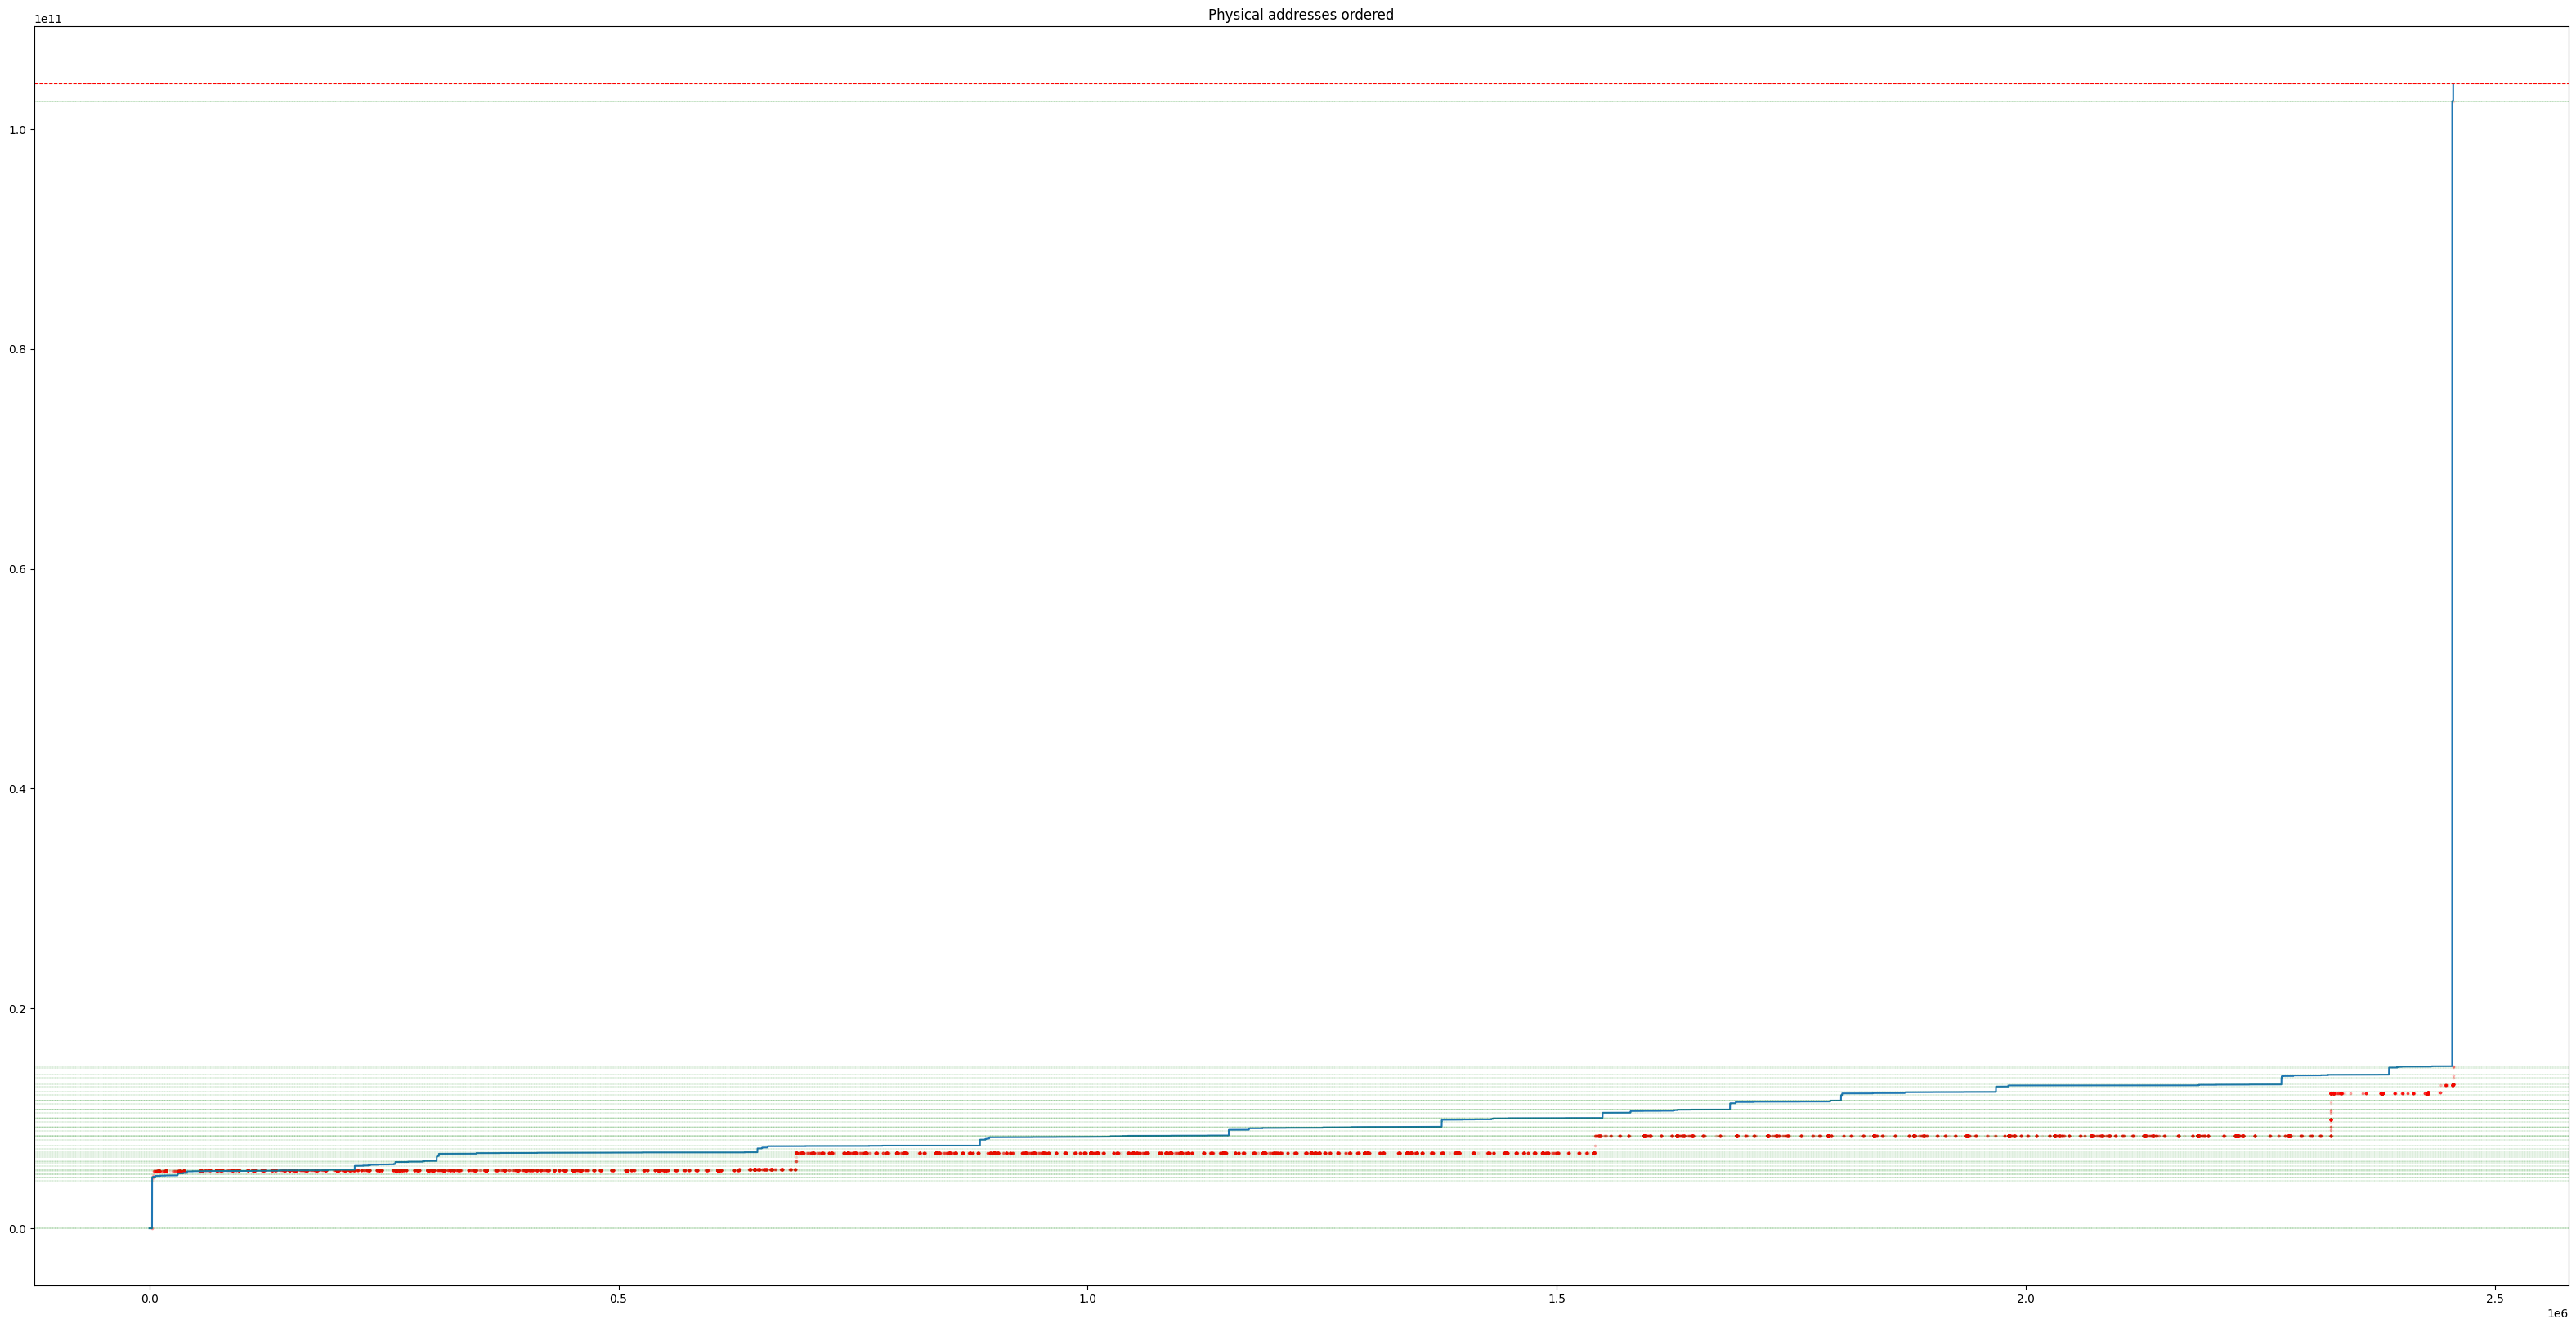

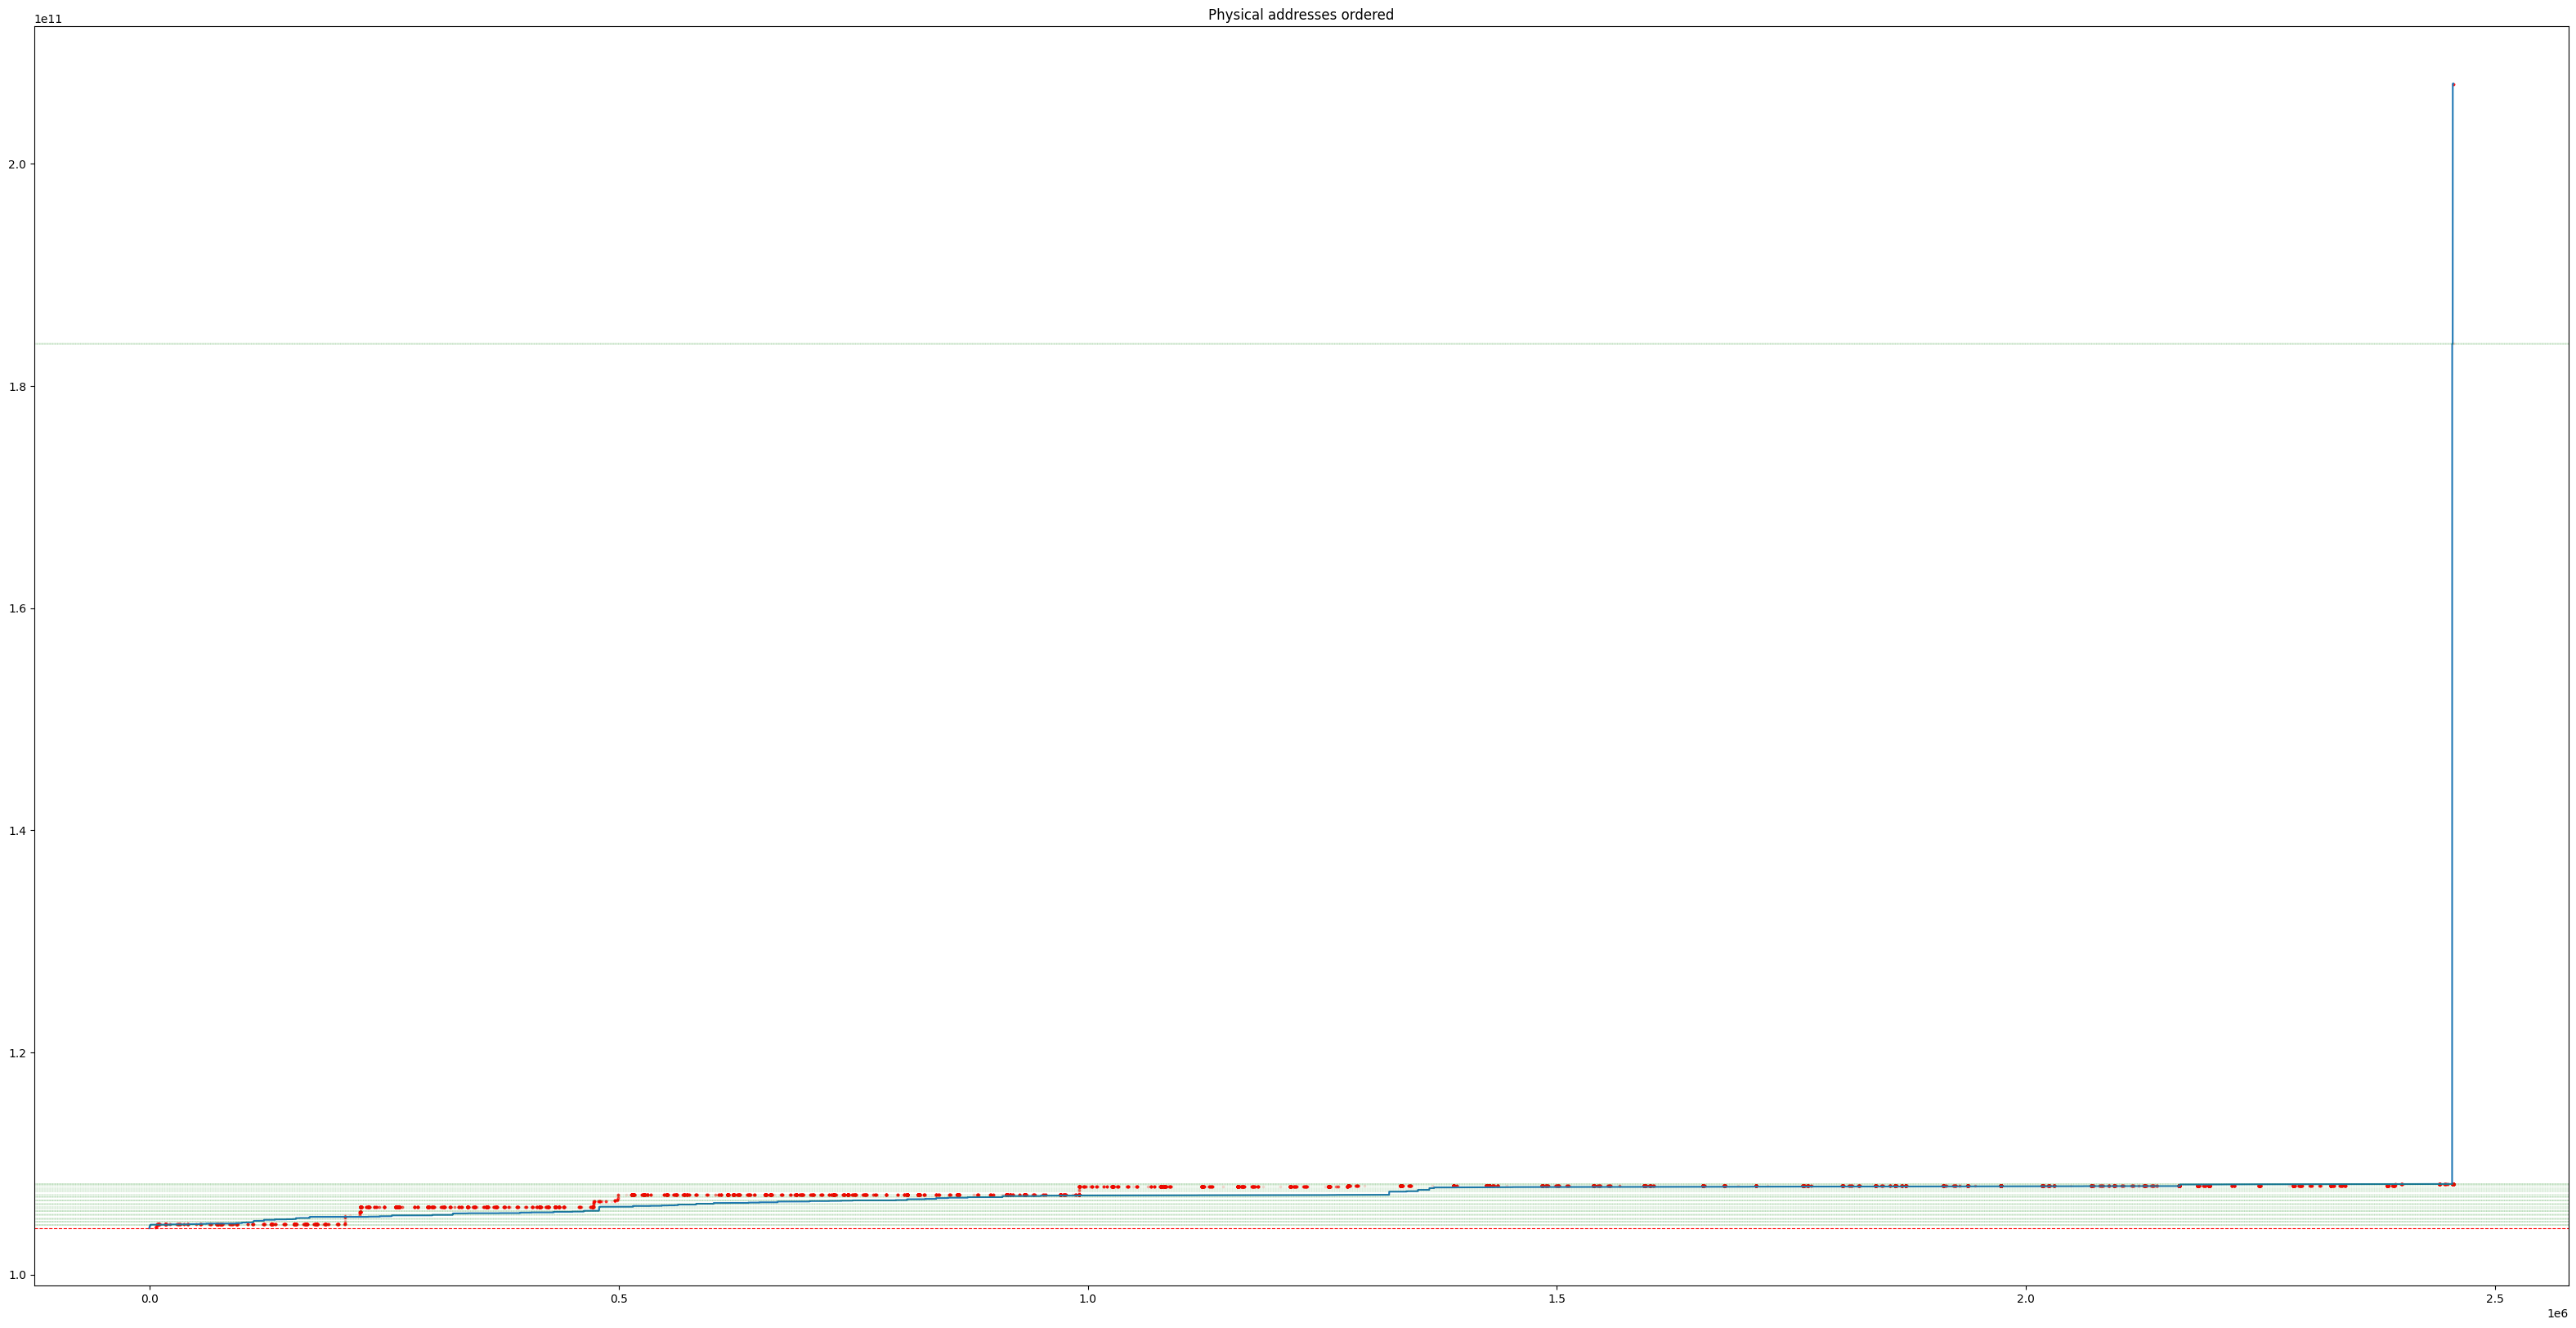

In [33]:
plot_phys_addresses(events_df, 3e8, 100)
# plot_phys_addresses(events_df, 1, 3e8, 4000)

2455230
[(0, 4768752016, 4000), (4768752016, 5050765264, 15233), (5179839976, 5340254080, 84780), (5676761088, 5854359544, 20580), (5999163768, 6132071976, 21093), (6445565696, 6787297584, 4000), (6787297664, 6920601536, 158120), (7255359508, 7523631360, 112283), (8064425992, 8350477536, 65940), (8380219456, 8447328216, 59738), (8886911968, 9186911792, 59919), (9186912264, 9237954176, 47997), (9675163100, 9953050616, 25905), (9995026608, 10036969408, 55565), (10497093752, 10797093656, 50676), (10797093840, 10800331872, 13317), (11310219120, 11581202396, 61043), (11616125344, 11618221992, 6429), (12111364096, 12406751036, 95847), (12889359472, 13086228472, 177827), (13690425344, 13985906520, 66973), (14594826160, 14755561256, 40048), (102552979792, 104481915592, 4000), (104481915592, 104761218176, 54583), (104782430208, 105082388472, 30985), (105082855440, 105363881976, 80176), (105385693204, 105678872384, 73158), (105728680688, 105920071448, 8819), (106043658784, 106330405264, 54401), 

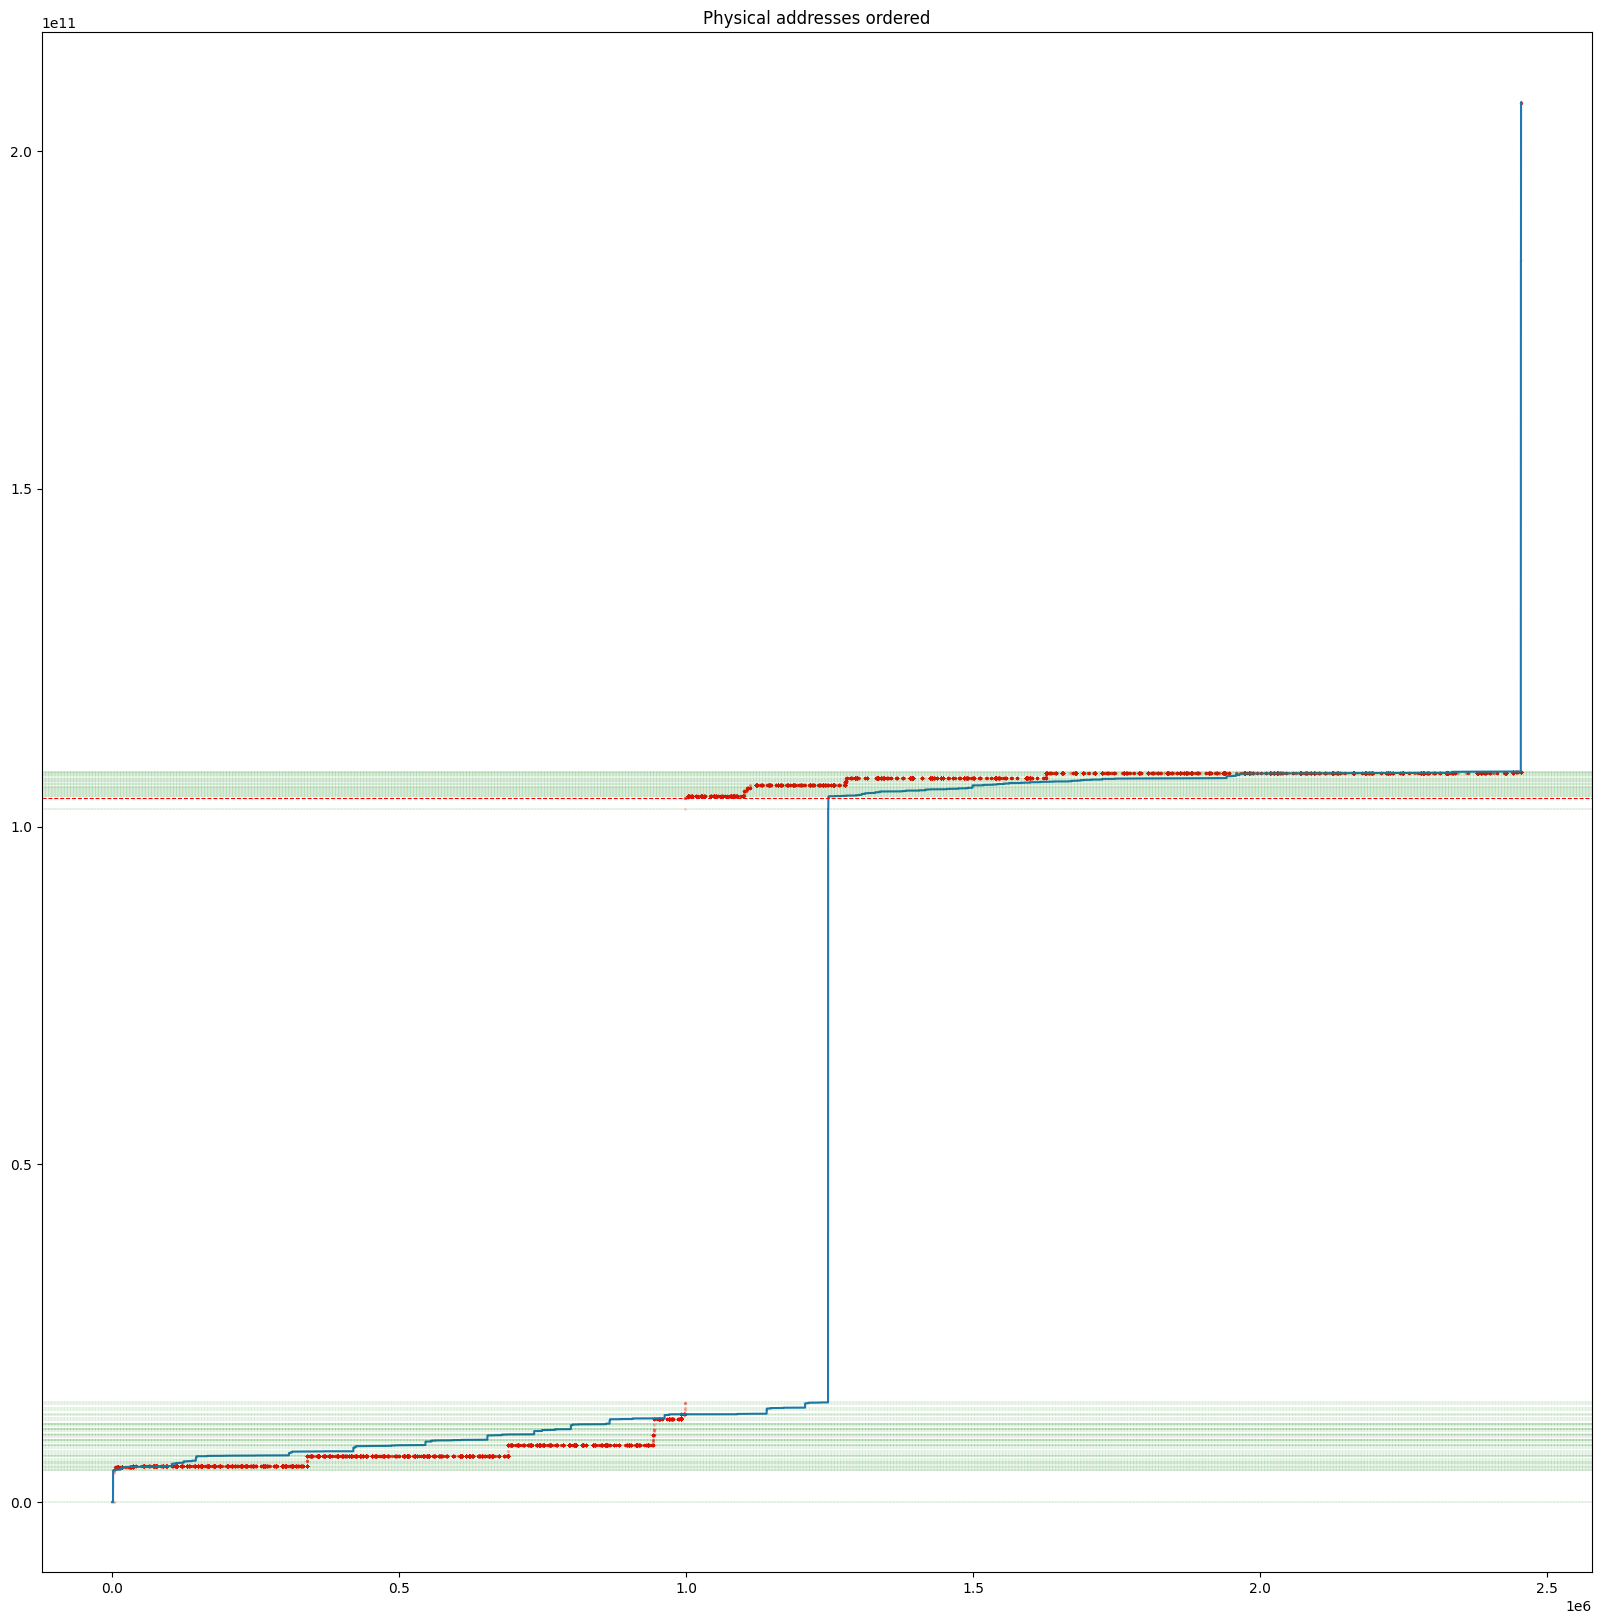

In [37]:
print(len(events_df))
phys_clusters = get_cluster_bounds(events_df['phys'].to_numpy(), 3e8, 4000)
print(phys_clusters)

# sorted_phys_addr = events_df['phys'].sort_values()

plt.plot(events_df.index, events_df['phys'].sort_values())
for cluster in phys_clusters :
    plt.axhline(y=cluster[0], color='g', linestyle='--', linewidth=0.2)
    plt.axhline(y=cluster[1], color='g', linestyle='--', linewidth=0.2)

plt.scatter(l3_remote_df.index, l3_remote_df['phys'].sort_values(), s=2, color='r', alpha=0.1)

plt.axhline(y=NODE_1_PHYS_ADDR_START, color='r', linestyle='--', linewidth=0.8)
plt.gcf().set_size_inches(20, 20)
plt.title("Physical addresses ordered")
plt.show()

In [38]:
# Find out which clusters contain l3 remote misses ?

In [48]:
bounded_events_df = filter_in_bounds(events_df, "phys", phys_clusters[0])
cpu_bounded_events_df = bounded_events_df.loc[bounded_events_df['cpuid'] == 1]

cpu_events_df = events_df.loc[events_df['cpuid'] == 1]
l3_df = filter_l3_miss_retired_remote(events_df.loc[events_df['cpuid'] == 1])
# l3_df.loc[l3_df["cpu_node"] == l3_df["memory_node"]

In [51]:
bounded_events_df['event'].value_counts()

event
cpu/mem-loads/p                         41666
mem_load_l3_miss_retired.remote_dram        8
Name: count, dtype: int64

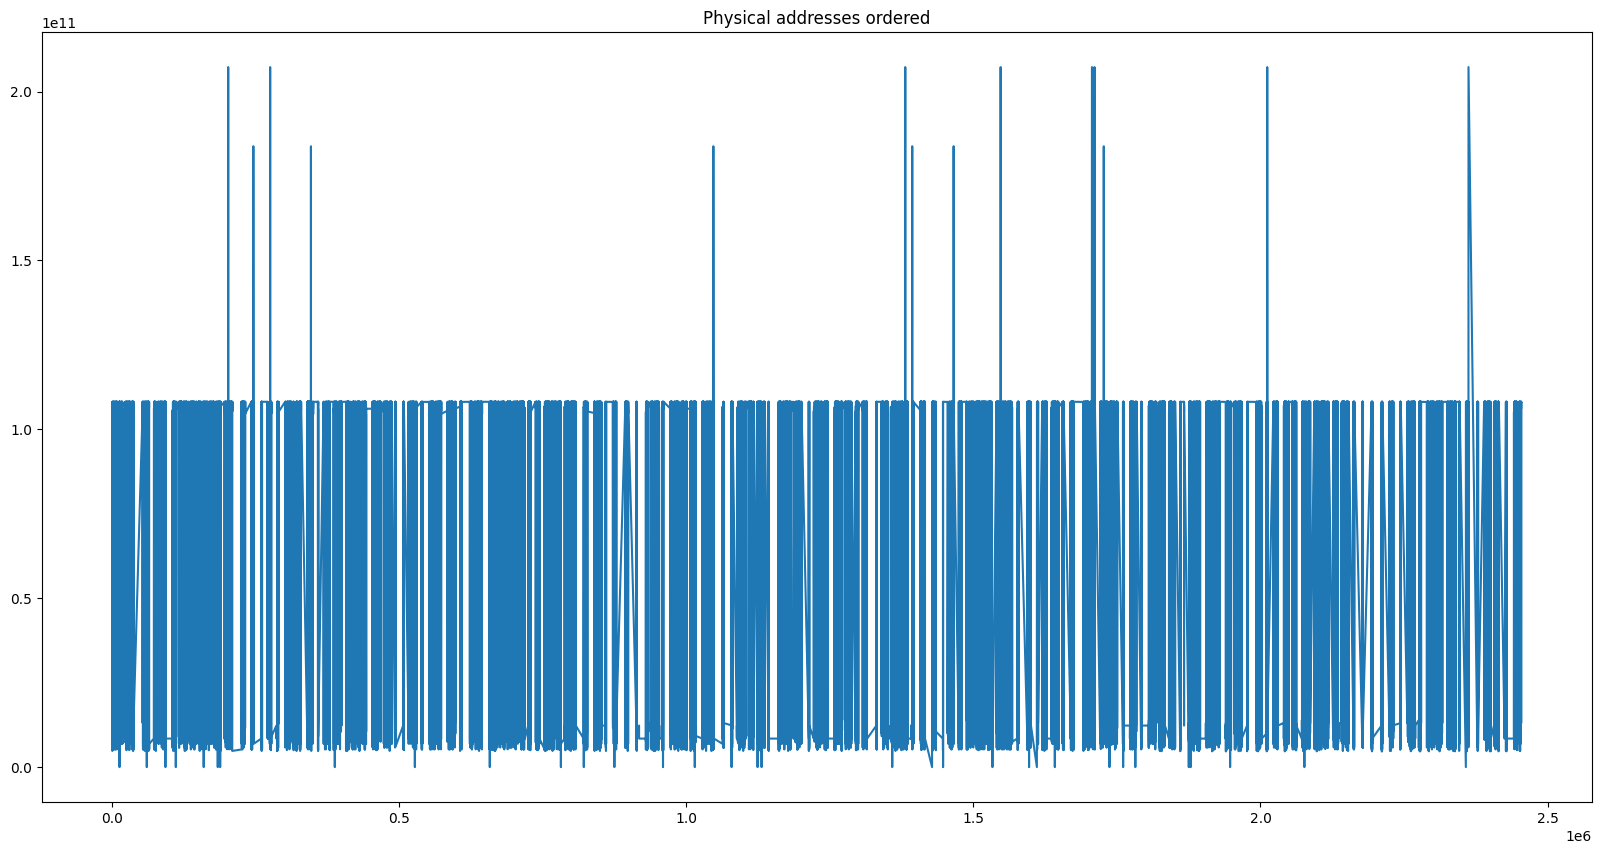

In [49]:
plt.plot(cpu_events_df.index, cpu_events_df['phys'])
# plt.axhline(y=NODE_1_PHYS_ADDR_START, color='r', linestyle='--')
plt.gcf().set_size_inches(20, 10)
plt.title("Physical addresses ordered")
plt.show()

In [70]:
def plot_with_l3_miss_remote(df: pd.DataFrame):
    loads_df = df.loc[df['event'] == "cpu/mem-loads/p"]
    l3_df = df.loc[df['event'] == "mem_load_l3_miss_retired.remote_dram"]
    plt.scatter(loads_df['time'], loads_df['phys'], label="loads df", s=6, alpha=0.5)
    plt.scatter(l3_df['time'], l3_df['phys'], label="l3 df", color='r', s=6, alpha=0.5)
        # break

    # fig = plt.gcf()
    # if width is None :
    #     width = 28
    # if height is None :
    #     height = 12
    # plt.gcf().set_size_inches(120, 60)
    plt.gcf().set_size_inches(20, 30)
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    plt.xlabel('Time')
    plt.ylabel('Phys')
    plt.title('Scatter Plot of Time vs Phys with Cache Results Colored')
    plt.legend(title='Cache Result')
    plt.show()

[(5271068992, 5278196160, 6000), (6840909824, 6902752688, 10006)]


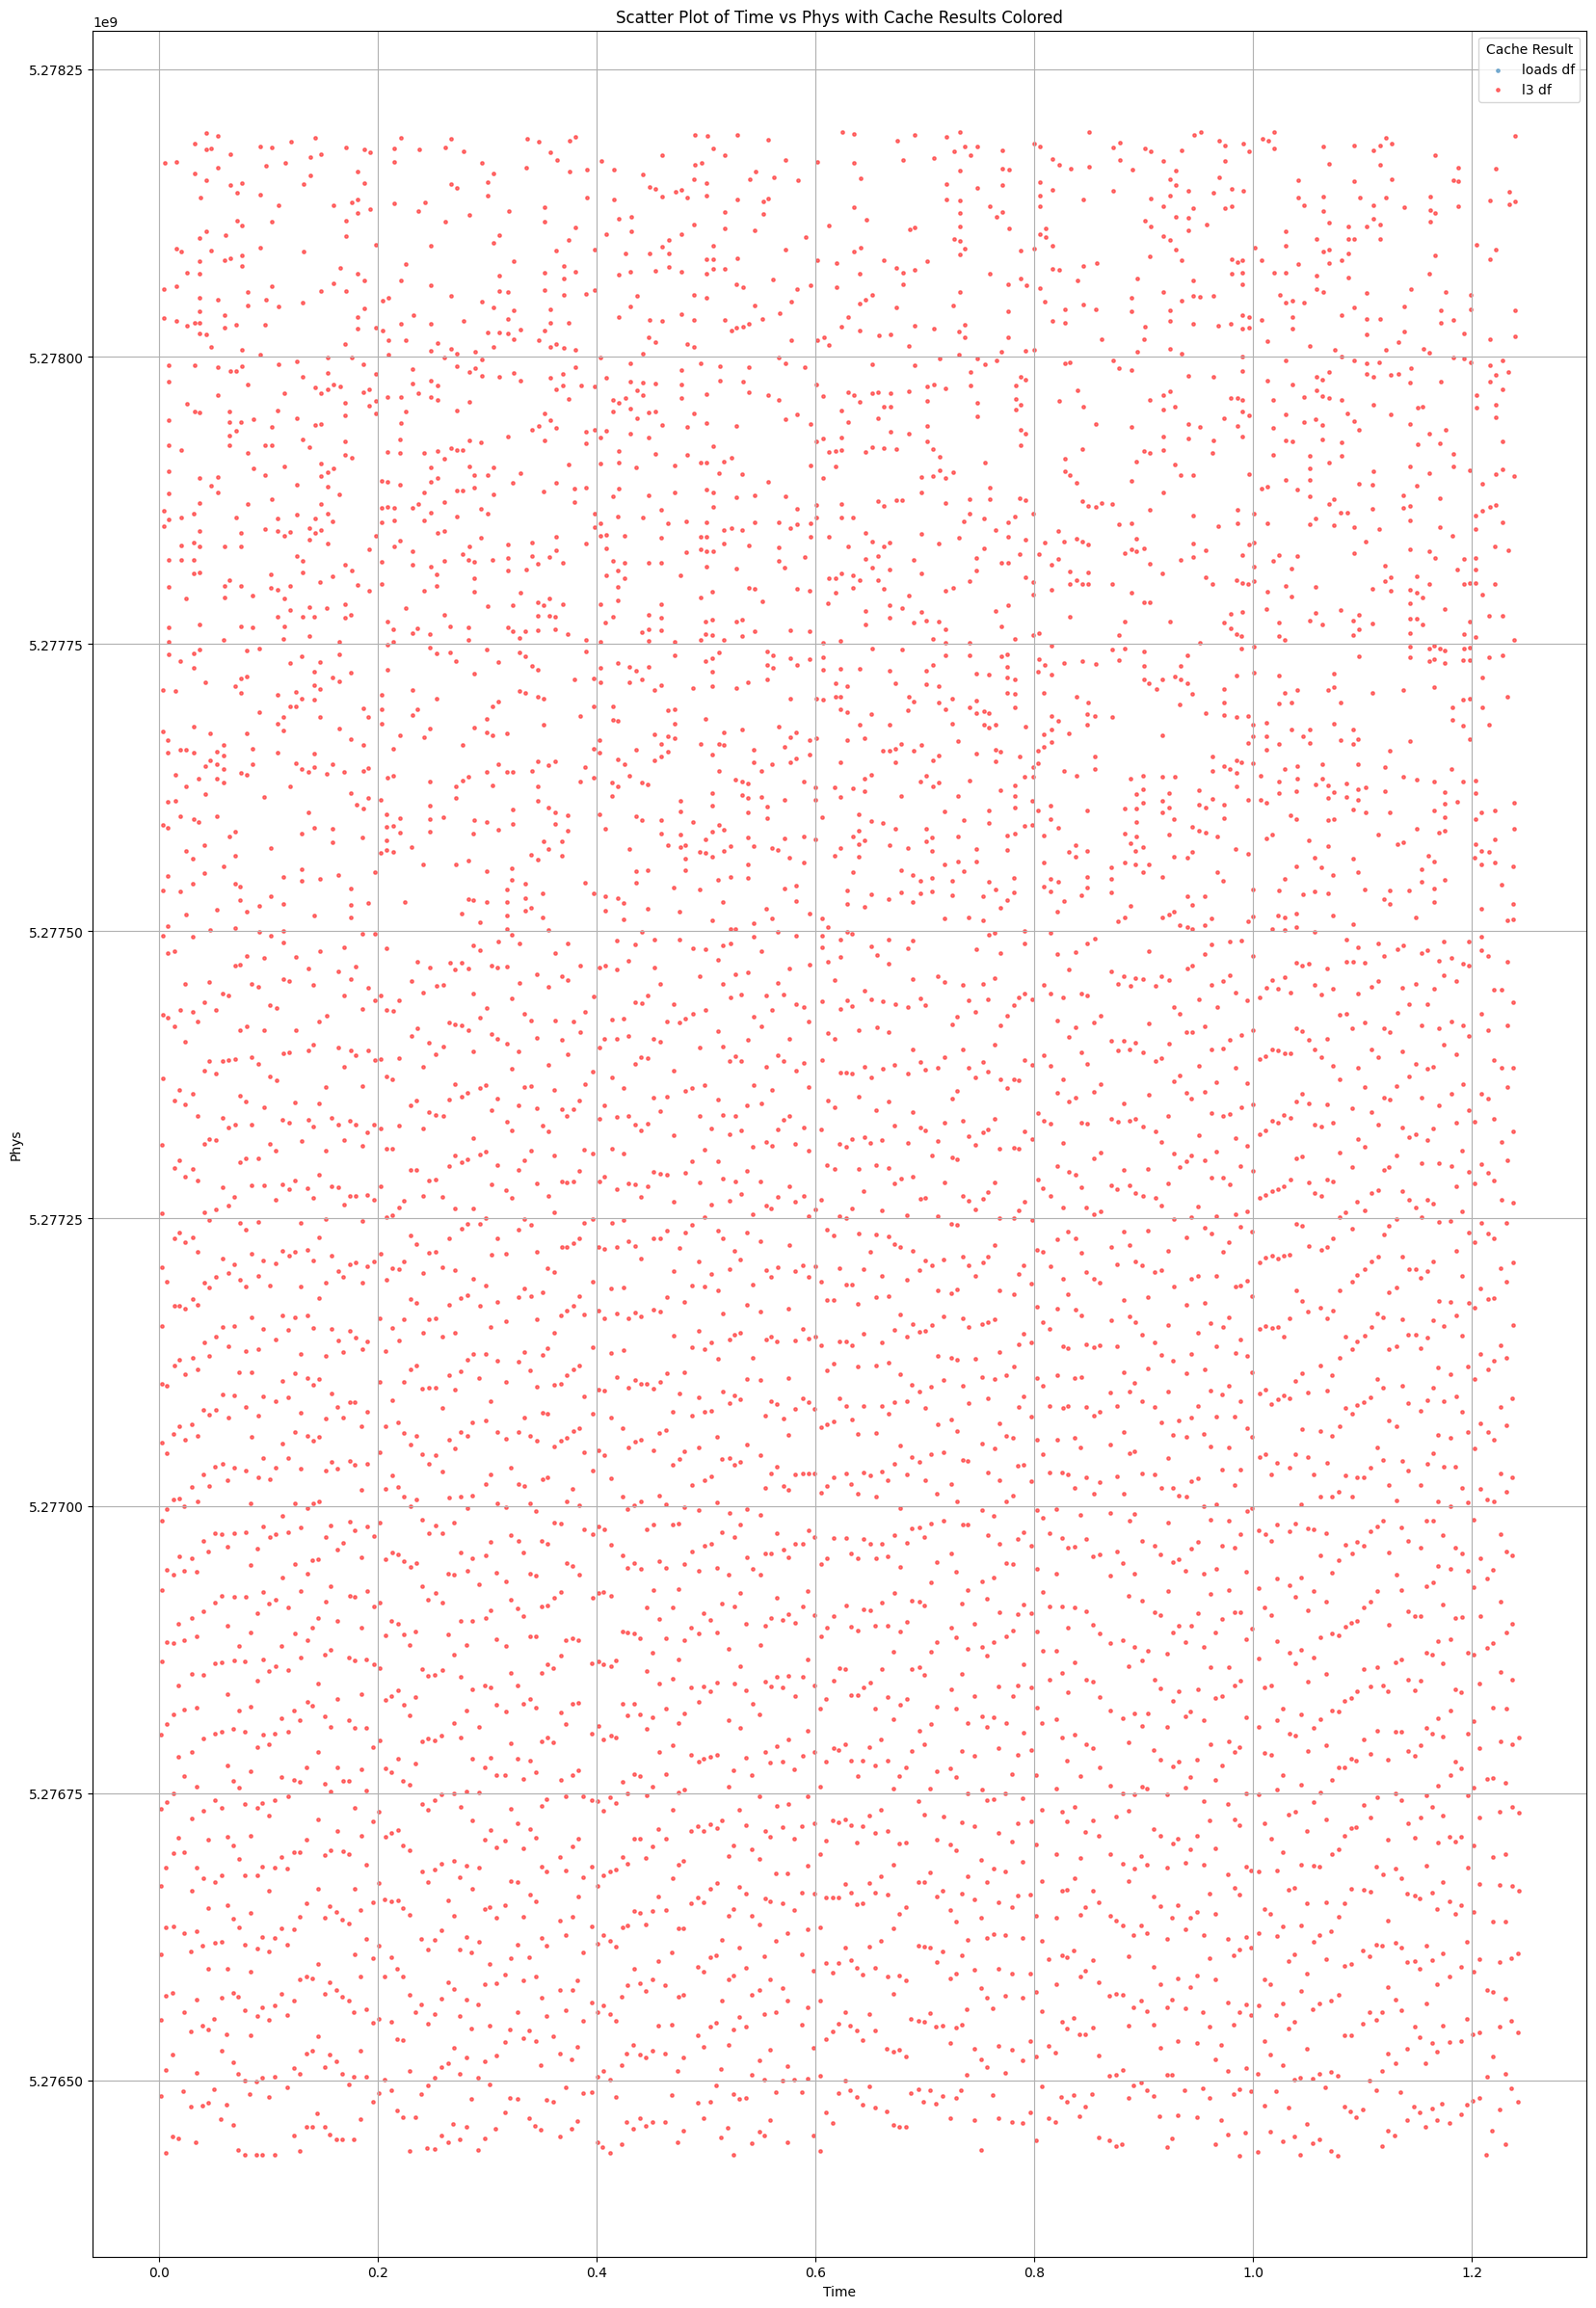

In [71]:
cpu_events_df = events_df.loc[events_df['cpuid'] == 25]
cpu_phys_bounds = get_cluster_bounds(filter_l3_miss_retired_remote(cpu_events_df)['phys'], 5e8, 500)
print(cpu_phys_bounds)
filtered_cpu_events_df = filter_in_bounds(cpu_events_df, 'phys', cpu_phys_bounds[0])
plot_with_l3_miss_remote(filtered_cpu_events_df)

In [68]:
filtered_cpu_events_df['cpuid'].value_counts()

cpuid
1    5942
Name: count, dtype: int64